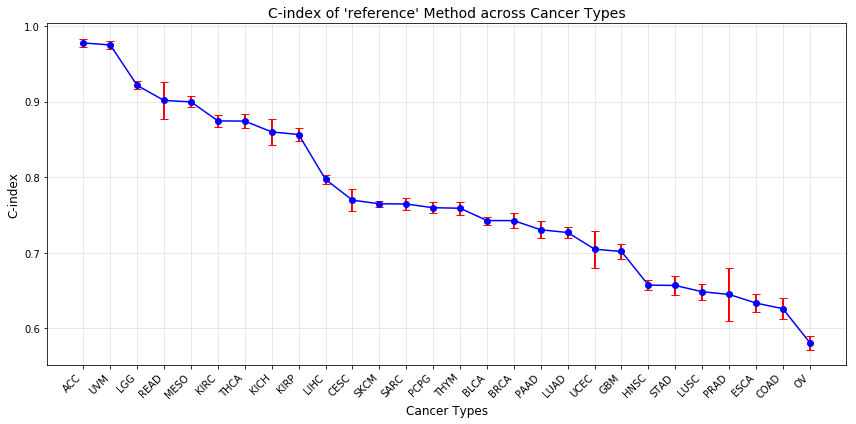

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load the data
data_path = "../result/C_index_result.csv"
data = pd.read_csv(data_path)
baseline_data = data[data['group'] == 'baseline']

# Function to calculate mean and 95% confidence interval
def calculate_mean_and_ci(values):
    mean = np.mean(values)
    ci = stats.sem(values) * stats.t.ppf((1 + 0.95) / 2, len(values) - 1)  
    return mean, mean - ci, mean + ci

# Group by Cancer_type and calculate mean and CI for each group
ci_results = baseline_data.groupby('Cancer_type')['c_index'].apply(lambda x: calculate_mean_and_ci(x)).apply(pd.Series)
ci_results.columns = ['mean', 'ci_lower', 'ci_upper']
ci_results= ci_results.sort_values(by='mean', ascending=False)

# Plot the line graph with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(x=ci_results.index, 
             y=ci_results['mean'], 
             yerr=[ci_results['mean'] - ci_results['ci_lower'], 
                   ci_results['ci_upper'] - ci_results['mean']],
             fmt='o-', color='blue', ecolor='red', elinewidth=2, capsize=4, markerfacecolor='blue', markeredgecolor='blue')

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.title("C-index of 'reference' Method across Cancer Types", fontsize=14)
plt.xlabel("Cancer Types", fontsize=12)
plt.ylabel("C-index", fontsize=12)
plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5)  
plt.tight_layout()

# Save the plot
plt.savefig("Fig_2B.png", dpi=300)
plt.show()

<Figure size 1296x864 with 0 Axes>

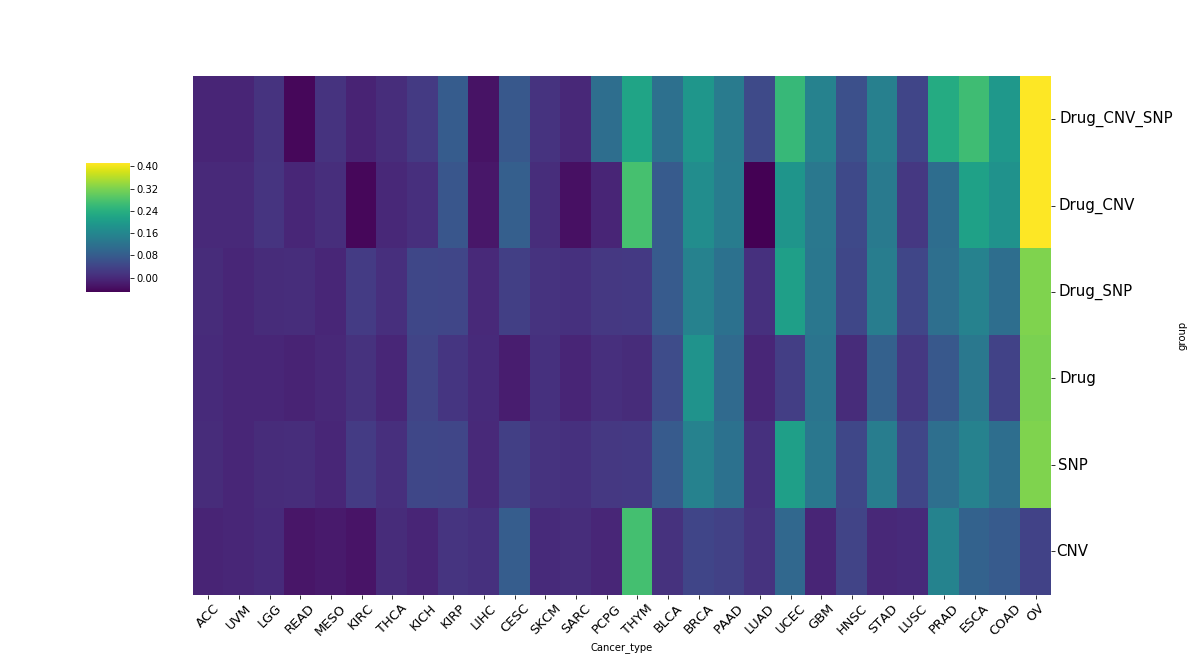

In [23]:
df_mean = data.groupby(["Cancer_type", "group"])["c_index"].mean().unstack()

# Sort by baseline and calculate relative delta
df_mean_sorted = df_mean.sort_values(by='baseline', ascending=False)
df_delta_rel = df_mean_sorted.subtract(df_mean_sorted['baseline'], axis=0)
df_delta_rel = df_delta_rel.divide(df_mean_sorted['baseline'], axis=0).drop(columns=['baseline'])

# Reorder columns and transpose for plotting
reordered_columns = ['drug_cnv_snp', 'drug_cnv', 'drug_snp', 'drug', 'snp', 'cnv']
df_delta_rel = df_delta_rel[reordered_columns]
df_delta_rel_transposed = df_delta_rel.T
custom_xlabels = df_mean_sorted.index

# Create clustered heatmap
plt.figure(figsize=(18, 12))
clustered_heatmap_rel = sns.clustermap(df_delta_rel_transposed, 
                                        cmap='viridis', 
                                        cbar_kws={'shrink': 0.7}, 
                                        xticklabels=custom_xlabels,
                                        yticklabels=['Drug_CNV_SNP', 'Drug_CNV', 'Drug_SNP', 'Drug', 'SNP', 'CNV'],
                                        col_cluster=False, 
                                        row_cluster=False,
                                        figsize=(20, 12))

# Adjust subplot, labels, and colorbar position
clustered_heatmap_rel.fig.subplots_adjust(right=0.85, bottom=0.2)
plt.setp(clustered_heatmap_rel.ax_heatmap.get_xticklabels(), rotation=45, ha='center', fontsize=13)
plt.setp(clustered_heatmap_rel.ax_heatmap.get_yticklabels(), rotation=0, va='center', ha='right', fontsize=15)

y_labels = clustered_heatmap_rel.ax_heatmap.get_yticklabels()
manual_adjustments = {3: (0.01, 0), 2: (0.0528, 0), 1: (0.0552, 0), 0: (0.1, 0)}
for i, label in enumerate(y_labels):
    if i in manual_adjustments:
        x_offset, y_offset = manual_adjustments[i]
        current_pos = label.get_position()
        label.set_position((current_pos[0] + x_offset, current_pos[1] + y_offset))

clustered_heatmap_rel.cax.set_position([0.18, 0.55, 0.03, 0.15])
clustered_heatmap_rel.ax_heatmap.yaxis.set_tick_params(pad=33)

plt.savefig("Fig_2C.png", dpi=300)
plt.show()